In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
import pymc as pm 

## Week 10 Homework

---

### Q1: perform Bayesian Logistic Regression 

- For a binary outcome dataset you find interesting (perhaps from kaggle.com?)
- Model the outcome as a bernoulli random variable and use a **logit link** function
- Use `pm.Normal('betas', mu=0, sigma=1, shape=p)` rather than the `pm.MvNormal` version
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics

### Q2: perform Bayesian Multivariate Regression

- For a data set for which modeling multiple continuous outcomes might be interesting (perhaps from kaggle.com?)
- Use `pm.Normal('betas', mu=0, sigma=1, shape=(p,m))` rather than a `pm.MvNormal` alternative
- Use `y = pm.MvNormal('y', mu=X@betas, chol=L, observed=x)` for `(n,m)` shaped `y` and `(n,p)` shaped `X`
- Downsample your dataset to tentatively explore the effect of different values of `n`,`m`,`p` and 
    - report on your findings and based on that 
    - choose a "reasonably small" sized data set to perform an actual analysis
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, alpha]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


           mean     sd  hdi_3%  hdi_97%
betas[0] -0.131  0.488  -1.005    0.811
betas[1]  4.301  0.482   3.403    5.193
betas[2] -0.046  0.461  -0.906    0.819
alpha    -0.985  0.450  -1.856   -0.145


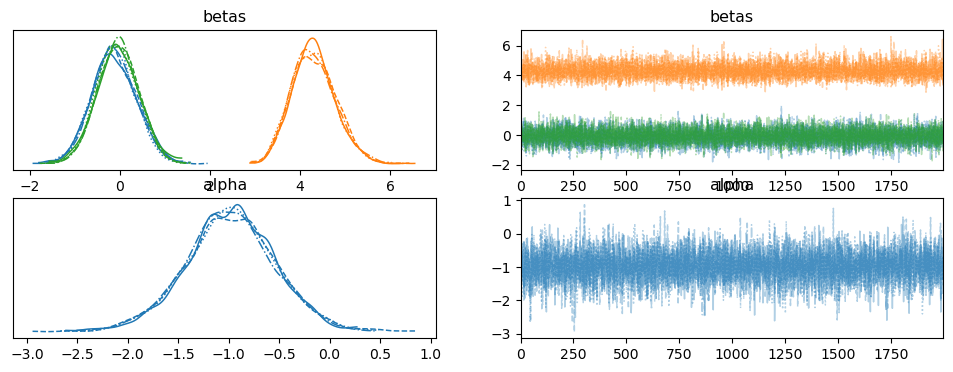

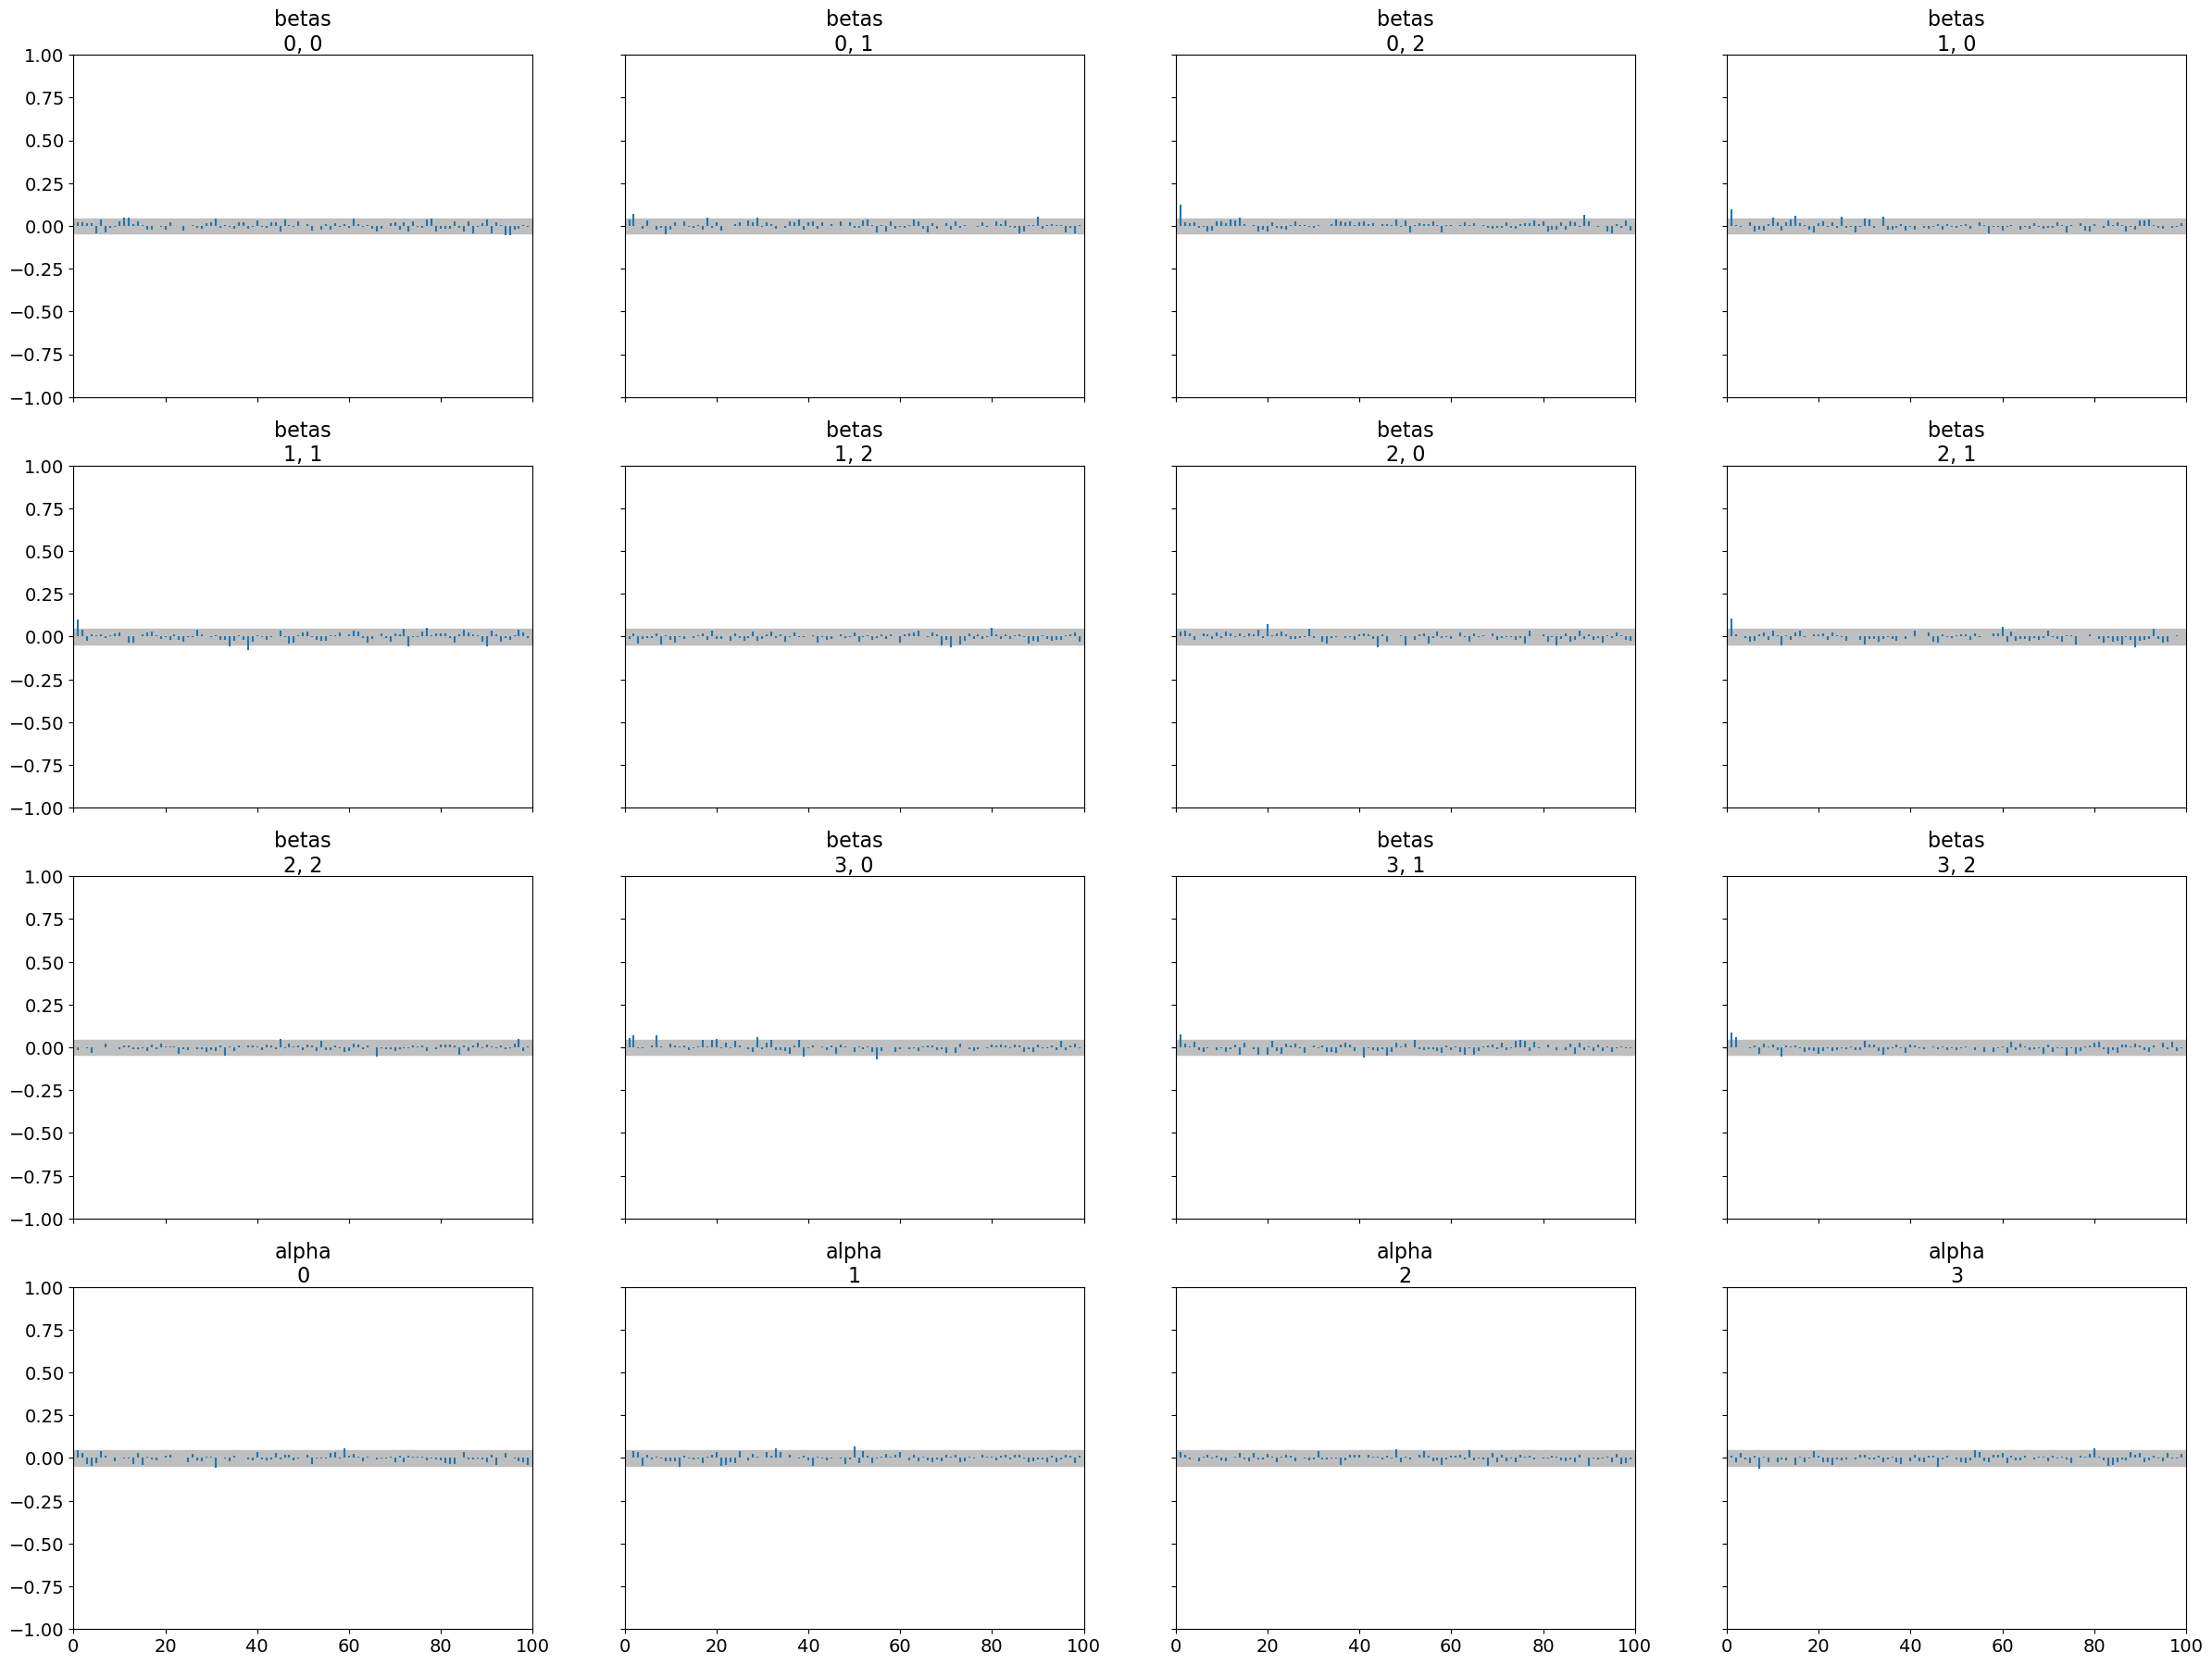

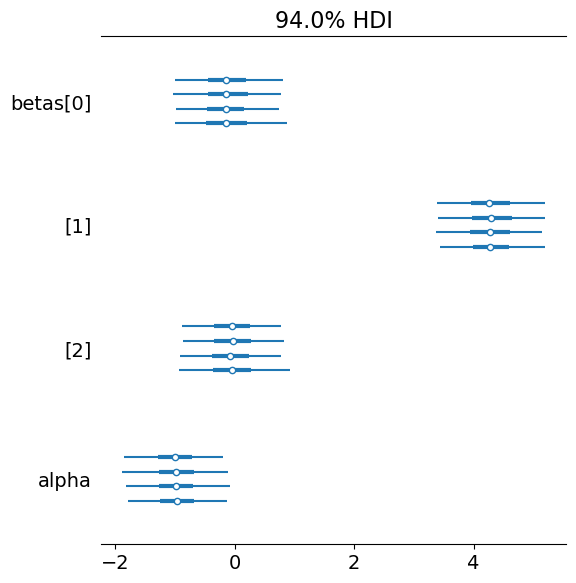

In [3]:
# Q1
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Load the Titanic dataset
df = pd.read_csv("Titanic.csv")

# 2. Select features and target variable
df = df[['Pclass', 'Sex', 'Age', 'Survived']].dropna()
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})  # Convert categorical variable to numerical
X = df[['Pclass', 'Sex', 'Age']].values
y = df['Survived'].values  # For a Bernoulli likelihood, a 1D array is sufficient

# 3. Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 4. Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=365
)

# 5. Define and run the Bayesian Logistic Regression model
with pm.Model() as logistic_model:
    # (a) Priors
    # Use pm.Normal('betas', mu=0, sigma=1, shape=p) as required
    betas = pm.Normal("betas", mu=0, sigma=1, shape=X_train.shape[1])
    alpha = pm.Normal("alpha", mu=0, sigma=1)

    # (b) Logit link for Bernoulli
    p = pm.math.sigmoid(alpha + pm.math.dot(X_train, betas))

    # (c) Bernoulli likelihood
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y_train)

    # (d) MCMC Sampling
    trace = pm.sample(
        2000, 
        tune=1000, 
        target_accept=0.9, 
        return_inferencedata=True,
        random_seed=365
    )

# 6. Posterior Analysis + MCMC Diagnostics
print(az.summary(trace, var_names=["betas", "alpha"], kind="stats"))

# Trace plots
az.plot_trace(trace, var_names=["betas", "alpha"])
plt.show()

# Autocorrelation plots
az.plot_autocorr(trace, var_names=["betas", "alpha"])
plt.show()

# Forest plot for credible intervals
az.plot_forest(trace, var_names=["betas", "alpha"])
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, alpha, chol_cov]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 119 seconds.


              mean     sd  hdi_3%  hdi_97%
betas[0, 0] -0.075  0.070  -0.215    0.046
betas[0, 1] -0.157  0.059  -0.274   -0.054
betas[1, 0] -0.256  0.039  -0.328   -0.183
betas[1, 1] -0.421  0.034  -0.482   -0.356
alpha[0]     0.012  0.050  -0.083    0.109
alpha[1]    -0.246  0.044  -0.329   -0.161


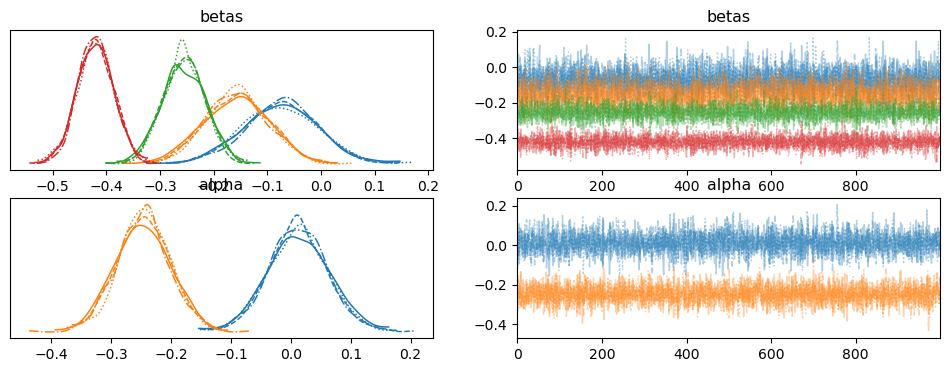

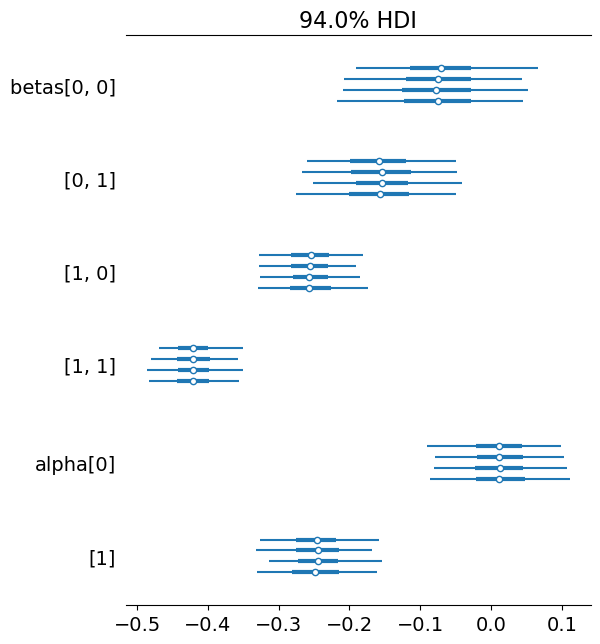

In [8]:
# Q2
import pandas as pd
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Load dataset
df = pd.read_csv("wine-quality-white-and-red.csv", sep=',', header=0)

# 2. Strip spaces from column names
df.rename(columns=lambda x: x.strip(), inplace=True)

# 3. Select predictor and target variables
y = df[['pH', 'alcohol']].values  # shape (n, 2)
X = df[['volatile acidity', 'residual sugar']].values  # shape (n, 2)

# 4. Standardize data
X = StandardScaler().fit_transform(X)
y = StandardScaler().fit_transform(y)

# 5. Downsample dataset for faster performance (Take first 200 rows)
X, y = X[:500], y[:500]

# 6. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=365
)

n, m = y_train.shape  # (n samples, m dependent variables)
p = X_train.shape[1]  # (p independent variables)

# 7. Define Bayesian Multivariate Regression Model
with pm.Model() as model:
    # Priors for regression coefficients
    betas = pm.Normal("betas", mu=0, sigma=1, shape=(p, m))
    alpha = pm.Normal("alpha", mu=0, sigma=1, shape=(m,))

    # Linear predictor for each target
    mu = pm.math.dot(X_train, betas) + alpha[None, :]

    # Covariance matrix
    chol, corr, stds = pm.LKJCholeskyCov(
        "chol_cov", n=m, eta=1, sd_dist=pm.HalfNormal.dist(1), compute_corr=True
    )
    cov_matrix = pm.Deterministic("cov_matrix", chol.dot(chol.T))

    # Multivariate Normal likelihood
    y_obs = pm.MvNormal("y_obs", mu=mu, cov=cov_matrix, observed=y_train)

    # MCMC Sampling (Reduced steps for speed)
    trace = pm.sample(
        1000, tune=1000, target_accept=0.98, random_seed=365,
        return_inferencedata=True
    )

# 8. Posterior analysis and MCMC diagnostics
print(az.summary(trace, var_names=["betas", "alpha"], kind="stats"))

az.plot_trace(trace, var_names=["betas", "alpha"])
plt.show()

az.plot_forest(trace, var_names=["betas", "alpha"])
plt.show()


### Probit Regression (as opposed to Logistic Regression)

- $\Phi$ is CDF of standard normal (and is also call the **inverse probit** function)
    - The **probit** function is $\Phi^{-1}$
- $z_i \sim N(x_i^\top\beta,1)$


$$\int \Phi(z_i)^{y_i} (1-\Phi(z_i))^{1-y_i}d\Phi(z) = \Phi(x_i^\top\beta)^{y_i} (1-\Phi(x_i^\top\beta))^{1-y_i} = p_i^{y_i} (1-p_i)^{1-y_i} $$

### Q3: perform Bayesian Multivariate Classification

- For a data set for which modeling multiple binary outcomes might be interesting (perhaps from kaggle.com?)
- Use `pm.Normal('betas', mu=0, sigma=1, shape=(p,m))` rather than a `pm.MvNormal` alternative
- Use `y = pm.Bernoulli('y', p=pm.math.invprobit(X@betas), observed=x)` for `(n,m)` shaped `y` and `(n,p)` shaped `X`
- Use latent `z = pm.MvNormal('z', mu=X@betas, chol=L)` as discussed in the "Generalized Linear Models (GLM)" section of the previous weeks lecture notes

> This provides normally distributed latent variables connected to the observed binary outcomes on which a latent covariance dependency structure may be modelled and estimated on the basis of imputing the unobserved latent variables based on their connection with the observed binary outcome variables.

- Downsample your dataset to tentatively explore the effect of different values of `n`,`m`,`p` and 
    - report on your findings and based on that 
    - choose a "reasonably small" sized data set to perform an actual analysis
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, alpha, chol_cov, z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1269 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 3946 divergences after tuning. Increase `target_accept` or reparameterize.


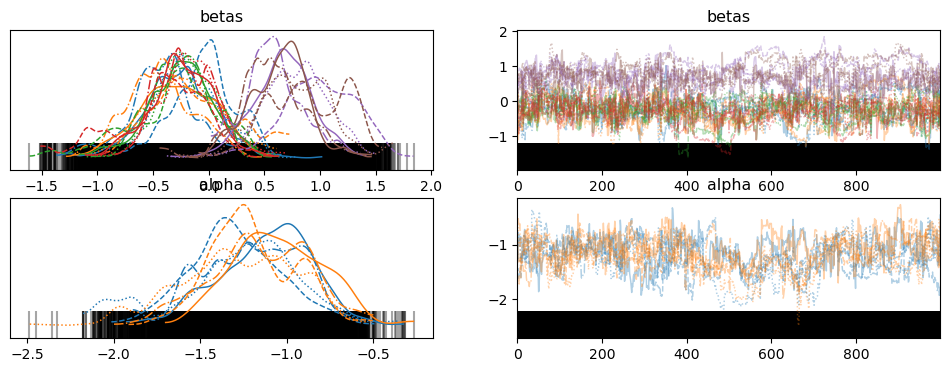

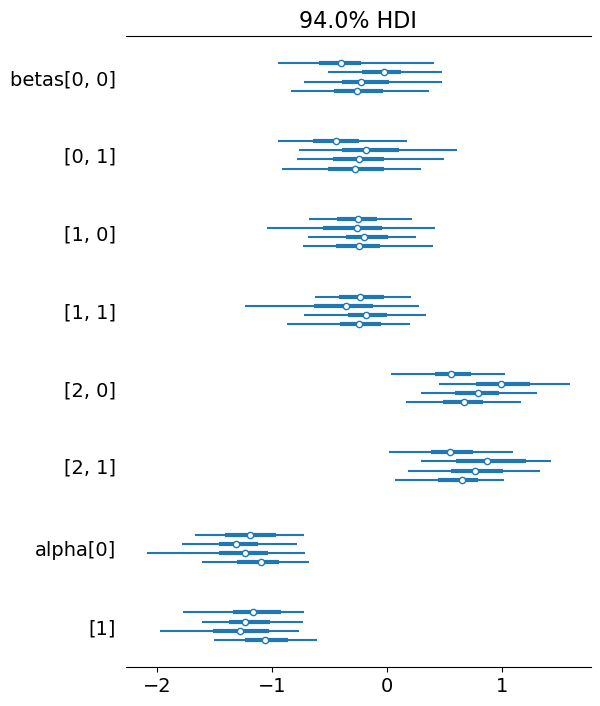

In [2]:
# Q3
import pandas as pd
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Load Titanic dataset
df = pd.read_csv("Titanic.csv")

# 2. Select relevant features and target variables
df = df[['Pclass', 'Age', 'Fare', 'Sex', 'Survived']].dropna()

# Convert categorical variable 'Sex' into binary format
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

# Define target variables (two binary outcomes: 'Survived' and 'Sex')
y = df[['Survived', 'Sex']].values  # Shape (n, 2)

# Define predictor variables (Pclass, Age, Fare)
X = df[['Pclass', 'Age', 'Fare']].values  # Shape (n, p)

# 3. Standardize predictor variables (Do not standardize binary targets)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 4. Downsample dataset for efficiency (take first 500 samples)
X, y = X[:500], y[:500]

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=365
)

n, m = y_train.shape  # (n samples, m dependent variables)
p = X_train.shape[1]  # (p independent variables)

# 6. Define Bayesian Multivariate Classification Model
with pm.Model() as model:
    # (a) Priors for regression coefficients
    betas = pm.Normal("betas", mu=0, sigma=1, shape=(p, m))
    alpha = pm.Normal("alpha", mu=0, sigma=1, shape=(m,))

    # (b) Latent variable following a Multivariate Normal distribution
    chol, corr, stds = pm.LKJCholeskyCov(
    "chol_cov", n=m, eta=2, sd_dist=pm.HalfNormal.dist(1), compute_corr=True
    )
    z = pm.MvNormal("z", mu=pm.math.dot(X_train, betas) + alpha[None, :], chol=chol, shape=(n, m))

    # (c) Probit link function (inverse probit transformation)
    p_y = pm.math.invprobit(z)

    # (d) Bernoulli likelihood for binary outcomes
    y_obs = pm.Bernoulli("y_obs", p=p_y, observed=y_train)

    # (e) MCMC Sampling
    trace = pm.sample(
        1000, tune=1000, target_accept=0.98, random_seed=365,
        return_inferencedata=True
    )

# 7. Posterior analysis and MCMC diagnostics
print(az.summary(trace, var_names=["betas", "alpha"], kind="stats"))

az.plot_trace(trace, var_names=["betas", "alpha"])
plt.show()

az.plot_forest(trace, var_names=["betas", "alpha"])
plt.show()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [betas, alpha, chol_cov, z]


Sampling 2 chains for 800 tune and 800 draw iterations (1_600 + 1_600 draws total) took 1179 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%
betas[0, 0] -0.140  0.261  -0.636    0.340
betas[0, 1] -0.140  0.255  -0.615    0.313
betas[1, 0] -0.258  0.229  -0.682    0.169
betas[1, 1] -0.258  0.236  -0.732    0.147
betas[2, 0]  0.299  0.250  -0.157    0.786
betas[2, 1]  0.305  0.240  -0.150    0.739
alpha[0]    -0.401  0.210  -0.804   -0.012
alpha[1]    -0.403  0.223  -0.806    0.028


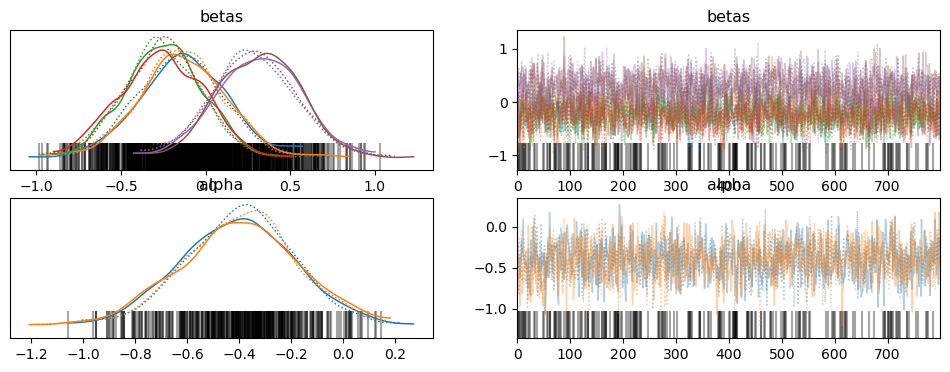

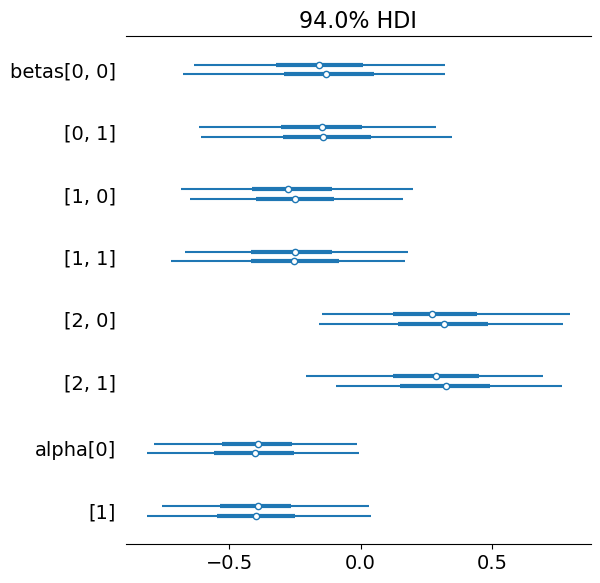

In [1]:
# Q3
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load Titanic dataset
df = pd.read_csv("Titanic.csv")

# Select relevant features and target variables
df = df[['Pclass', 'Age', 'Fare', 'Sex', 'Survived']].dropna()

# Convert categorical variable 'Sex' into binary format
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

# Define target variables (two binary outcomes: 'Survived' and 'Sex')
y = df[['Survived', 'Sex']].values  # Shape (n, 2)

# Define predictor variables (Pclass, Age, Fare)
X = df[['Pclass', 'Age', 'Fare']].values  # Shape (n, p)

# Standardize predictor variables (Do not standardize binary targets)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Downsample dataset for efficiency (take first 200 samples)
X, y = X[:200], y[:200]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

n, m = y_train.shape  # (n samples, m dependent variables)
p = X_train.shape[1]  # (p independent variables)

# Define Bayesian Multivariate Classification Model
with pm.Model() as model:
    # Priors for regression coefficients
    betas = pm.Normal("betas", mu=0, sigma=0.5, shape=(p, m))
    alpha = pm.Normal("alpha", mu=0, sigma=0.5, shape=(m,))

    # Improved latent variable covariance matrix with LKJ distribution
    chol, corr, stds = pm.LKJCholeskyCov(
        "chol_cov", n=m, eta=2, sd_dist=pm.HalfNormal.dist(0.5), compute_corr=True
    )

    # Latent variable (Multivariate Normal)
    z = pm.MvNormal(
        "z",
        mu=pm.math.dot(X_train, betas) + alpha[None, :],
        chol=chol,
        shape=(n, m),
    )

    # Probit link function (inverse probit transformation)
    p_y = pm.math.invprobit(z)

    # Bernoulli likelihood for binary outcomes
    y_obs = pm.Bernoulli("y_obs", p=p_y, observed=y_train)

    # Improved MCMC Sampling
    trace = pm.sample(
        800, tune=800, target_accept=0.99, init="jitter+adapt_diag",
        chains=2, cores=1, random_seed=365, return_inferencedata=True
    )

# Posterior analysis and MCMC diagnostics
print(az.summary(trace, var_names=["betas", "alpha"], kind="stats"))

az.plot_trace(trace, var_names=["betas", "alpha"])
plt.show()

az.plot_forest(trace, var_names=["betas", "alpha"])
plt.show()

